## Libraries

In [74]:
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
from skimage import io, color, feature
import skimage
from skimage import io, measure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pickle


### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [66]:
parent_path='/content/drive/MyDrive/Cancer Data'
os.chdir(parent_path)

In [67]:
df=pd.read_csv('metadata.csv')
df

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,PAT_1708,3156,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1708_3156_175.png,False
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True
2295,PAT_1343,1217,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,...,NaN,SEK,False,False,False,False,False,False,PAT_1343_1217_404.png,False
2296,PAT_326,690,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,...,4.0,BCC,True,False,False,False,False,True,PAT_326_690_823.png,True


In [68]:
new_df=df[['img_id','diagnostic']]
new_df.loc[new_df['diagnostic'].isin(['BCC', 'MEL', 'SCC']), 'diagnostic'] = 'Cancerous'
new_df.loc[new_df['diagnostic'].isin(['ACK', 'NEV', 'SEK']), 'diagnostic'] = 'Not Cancerous'
new_df

<ipython-input-68-0f0c74bc667b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[new_df['diagnostic'].isin(['BCC', 'MEL', 'SCC']), 'diagnostic'] = 'Cancerous'
<ipython-input-68-0f0c74bc667b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[new_df['diagnostic'].isin(['ACK', 'NEV', 'SEK']), 'diagnostic'] = 'Not Cancerous'


,img_id,diagnostic
0,PAT_1516_1765_530.png,Not Cancerous
1,PAT_46_881_939.png,Cancerous
2,PAT_1545_1867_547.png,Not Cancerous
3,PAT_1989_4061_934.png,Not Cancerous
4,PAT_684_1302_588.png,Cancerous
...,...,...
2293,PAT_1708_3156_175.png,Not Cancerous
2294,PAT_46_880_140.png,Cancerous
2295,PAT_1343_1217_404.png,Not Cancerous
2296,PAT_326_690_823.png,Cancerous


## PreProcessing

In [38]:
images_path=parent_path+"/images"
def resize_images(images_path,folder_name):
    # Create the folder if it doesn't exist
    resized_folder_path = os.path.join(os.path.dirname(images_path),folder_name)
    os.makedirs(resized_folder_path, exist_ok=True)
    
    # Loop through all the images in the "images" folder
    for filename in os.listdir(images_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Open the image
            with Image.open(os.path.join(images_path, filename)) as img:
                # Resize the image
                resized_img = img.resize((128, 128))

                # Save the resized image into the folder
                resized_img.save(os.path.join(resized_folder_path, f"{filename.split('.')[0]}_resized.png"))
resize_images(images_path,"Resized Images")

## Feature Extraction

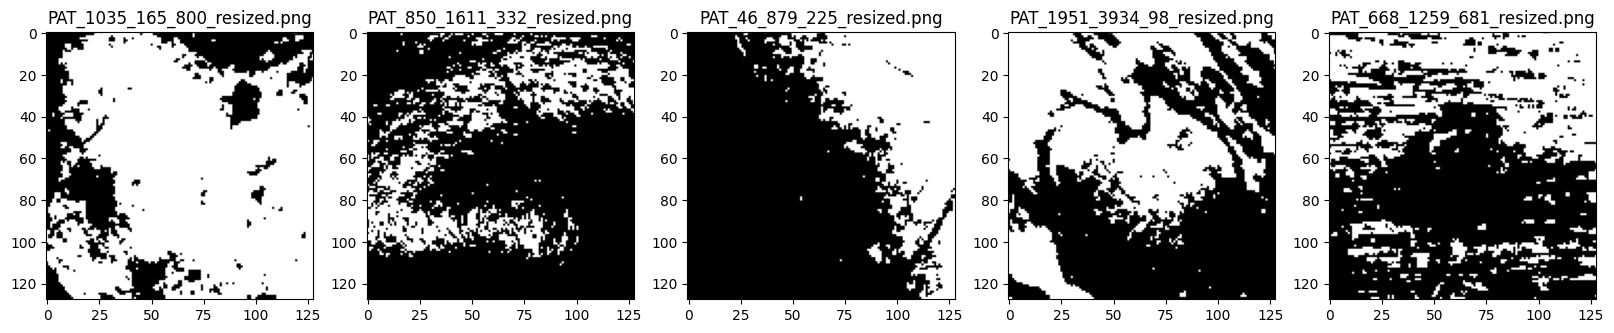

In [7]:
def threshhold_segmented_images(images_path, n_images):
    fig, axs = plt.subplots(1, n_images, figsize=(20, 20))
    # randomly select n_images from images_path
    selected_images = random.sample(os.listdir(images_path), n_images)
    for i in range(n_images):
        # read the image
        img_path = os.path.join(images_path, selected_images[i])
        img = cv2.imread(img_path)

        # convert to grayscale and apply thresholding
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        # display the segmented image
        axs[i].imshow(thresh, cmap='gray')
        axs[i].set_title(selected_images[i])

    plt.show()


resized_images_path=parent_path+'/Resized Images'
threshhold_segmented_images(resized_images_path,5)
    


In [30]:
def asymmetry_analysis(images_path,image_names):
    asymmetry_features = []
    for image_name in image_names:
        image_name=image_name.replace('.png','')

        image_path = os.path.join(images_path, image_name+"_resized.png")

        if os.path.isfile(image_path):
            # Load the image
            img = cv2.imread(image_path)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Threshold the image
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            # Find contours
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # Get the largest contour
            largest_contour = max(contours, key=cv2.contourArea)
            # Create a mask for the contour
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [largest_contour], -1, 255, -1)
            # Get the region of interest (ROI)
            roi = cv2.bitwise_and(gray, mask)
            # Find the horizontal and vertical axis of the ROI
            contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

            cnt = contours[0]
            (x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
            if angle > 90:
                angle = angle - 90
            else:
                angle = angle + 90
            # Rotate the ROI to align the axis
            M = cv2.getRotationMatrix2D((x,y),angle,1)
            rotated_roi = cv2.warpAffine(roi,M,(roi.shape[1],roi.shape[0]))
            # Compute the asymmetry feature
            asymmetry = np.sum(np.abs(roi - rotated_roi)) / np.sum(roi)
            asymmetry_features.append(asymmetry)
    return np.array(asymmetry_features)


In [31]:
asymmetry_features=asymmetry_analysis(resized_images_path,new_df['img_id'])

In [14]:
def color_features(images_path,imagenames):
    l_mean_list, l_std_list, a_mean_list, a_std_list, b_mean_list, b_std_list, color_hist_list = [], [], [], [], [], [], []
    for image_name in imagenames:
        image_name=image_name.replace('.png','')
        image_name=image_name+"_resized.png"
        image_path = os.path.join(images_path,image_name )
        if os.path.isfile(image_path) and image_name.endswith('.png'):
            # Load image
            img = io.imread(image_path)

            # Convert to RGB if RGBA
            if img.shape[-1] == 4:
                img = color.rgba2rgb(img)

            # Convert to LAB color space
            lab = color.rgb2lab(img)

            # Compute mean and standard deviation of L, a, b channels
            l_mean, a_mean, b_mean = np.mean(lab[:,:,0]), np.mean(lab[:,:,1]), np.mean(lab[:,:,2])
            l_std, a_std, b_std = np.std(lab[:,:,0]), np.std(lab[:,:,1]), np.std(lab[:,:,2])

            # Compute color histogram features
            hist, _ = np.histogram(lab[:,:,0], bins=256)
            color_hist = hist / np.sum(hist) # normalize histogram
            # Append features to array
            l_mean_list.append(l_mean)
            l_std_list.append(l_std)
            a_mean_list.append(a_mean)
            a_std_list.append(a_std)
            b_mean_list.append(b_mean)
            b_std_list.append(b_std)
            color_hist_list.append(color_hist)
    
    return l_mean_list, l_std_list, a_mean_list, a_std_list, b_mean_list, b_std_list, color_hist_list
    
l_mean_list, l_std_list, a_mean_list, a_std_list, b_mean_list, b_std_list, color_hist_list=color_features(resized_images_path,new_df['img_id'])

In [16]:
def get_texture_features(img_folder, img_names):
    contrast = []
    correlation = []
    energy = []
    homogeneity = []
    haralick = []
    
    for img_name in img_names:
        img_name=img_name.replace('.png','')
        img_name=img_name+"_resized.png"
        img_path = os.path.join(img_folder, img_name)
        img = io.imread(img_path, as_gray=True)
        
        # Get GLCM texture features
        img_int = (img * 255).astype(np.uint8)

        glcm = skimage.feature.greycomatrix(img_int, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast.append(skimage.feature.greycoprops(glcm, 'contrast')[0, 0])
        correlation.append(skimage.feature.greycoprops(glcm, 'correlation')[0, 0])
        energy.append(skimage.feature.greycoprops(glcm, 'energy')[0, 0])
        homogeneity.append(skimage.feature.greycoprops(glcm, 'homogeneity')[0, 0])
    
    
    return np.array(contrast), np.array(correlation), np.array(energy), np.array(homogeneity)

contrast, correlation, energy, homogeneity = get_texture_features(resized_images_path, new_df['img_id'])


In [11]:
def get_shape_features(images_folder_path,image_names):
    # initialize feature lists
    area = []
    perimeter = []
    circularity = []
    solidity = []
    eccentricity = []
    major_axis_length = []
    minor_axis_length = []

    # loop through all images in folder
    for filename in image_names:
        # read image
        filename=filename.replace('.png','')
        filename=filename+"_resized.png"
        img_path = os.path.join(images_folder_path, filename)
        img = io.imread(img_path, as_gray=True)
        
        # threshold image
        threshold = 0.3  # adjust as needed
        binary = img > threshold

        # get regions
        regions = measure.regionprops(binary.astype(int))

        # loop through all regions
        for region in regions:
            # get shape features
            area.append(region.area)
            perimeter.append(region.perimeter)
            circularity.append(4 * np.pi * region.area / (region.perimeter ** 2+0.01))
            solidity.append(region.solidity)
            eccentricity.append(region.eccentricity)
            major_axis_length.append(region.major_axis_length)
            minor_axis_length.append(region.minor_axis_length)

    return [np.array(area), np.array(perimeter), np.array(circularity), np.array(solidity), np.array(eccentricity), np.array(major_axis_length), np.array(minor_axis_length)]


In [17]:
shape_features=get_shape_features(resized_images_path, new_df['img_id'])

In [18]:
def featurized_df(asymmetry_features,l_mean_list,l_std_list,a_mean_list,a_std_list,b_mean_list,b_std_list,contrast,correlation,energy,homogeneity,shape_features):
  new_df['Assymetry Feature']=asymmetry_features
  new_df['L Mean']=l_mean_list
  new_df['L Std']=l_std_list
  new_df['A Mean']=a_mean_list
  new_df['A Std']=a_std_list
  new_df['B Mean']=b_mean_list
  new_df['B Std']=b_std_list
  new_df['contrast']=contrast
  new_df['correlation']=correlation
  new_df['energy']=energy
  new_df['homogeneity']=homogeneity
  new_df['Area']=shape_features[0]
  new_df['Perimeter']=shape_features[1]
  new_df['Circularity']=shape_features[2]
  new_df['solidity']=shape_features[3]
  new_df['eccentricity']=shape_features[4]
  new_df['Major_Axis_Length']=shape_features[5]
  new_df['Minor_Axis_Length']=shape_features[6]


  col_b = new_df.pop('diagnostic')  # remove 'B' column and return it
  new_df.insert(len(new_df.columns), 'Labels', col_b)  # in

  return new_df


In [19]:
all_df=featurized_df(asymmetry_features,l_mean_list,l_std_list,a_mean_list,a_std_list,b_mean_list,b_std_list,contrast,correlation,energy,homogeneity,shape_features)

<ipython-input-18-d175c2d57708>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Assymetry Feature']=asymmetry_features
<ipython-input-18-d175c2d57708>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['L Mean']=l_mean_list
<ipython-input-18-d175c2d57708>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [26]:
all_df.to_csv('Features_Cancer.csv',index=False)

In [69]:
all_df=pd.read_csv("Features_Cancer.csv")
all_df

,Unnamed: 0,img_id,Assymetry Feature,L Mean,L Std,A Mean,A Std,B Mean,B Std,contrast,...,energy,homogeneity,Area,Perimeter,Circularity,solidity,eccentricity,Major_Axis_Length,Minor_Axis_Length,Labels
0,0,PAT_1516_1765_530.png,1.873823,52.284491,5.817839,13.835006,2.896241,30.063155,3.030512,7.267532,...,0.059443,0.409311,16190,677.545202,0.443180,0.989851,0.103072,148.635381,147.843731,Not Cancerous
1,1,PAT_46_881_939.png,1.334678,57.947647,7.328453,12.324443,4.602179,6.547437,5.280253,19.210938,...,0.033934,0.267594,16361,563.355339,0.647821,0.998596,0.055434,147.898710,147.671293,Cancerous
2,2,PAT_1545_1867_547.png,1.635181,52.799388,15.104166,24.144385,5.001901,13.263435,3.067531,52.818713,...,0.018957,0.187104,14305,906.789935,0.218617,0.873108,0.498041,152.771010,132.475922,Not Cancerous
3,3,PAT_1989_4061_934.png,1.401964,64.266446,9.892797,3.156888,2.825569,7.749947,6.494395,26.585691,...,0.026186,0.245312,16381,517.656854,0.768186,0.999817,0.022164,147.810685,147.774377,Not Cancerous
4,4,PAT_684_1302_588.png,1.549918,50.370582,6.578109,8.642356,3.555305,10.859200,2.506059,32.620571,...,0.032815,0.255778,16315,651.166522,0.483518,0.995789,0.070524,148.035308,147.666716,Cancerous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,2293,PAT_1708_3156_175.png,1.210899,59.650202,10.747783,12.652326,3.541385,15.974075,4.230431,119.135212,...,0.017932,0.136279,16304,633.746212,0.510121,0.995117,0.034488,148.047226,147.959156,Not Cancerous
2294,2294,PAT_46_880_140.png,0.631327,59.099862,7.199962,9.223517,6.761065,6.699697,3.392910,13.690330,...,0.043880,0.339144,16379,520.071068,0.760978,0.999695,0.012508,147.819706,147.808142,Cancerous
2295,2295,PAT_1343_1217_404.png,1.307906,57.603283,8.466801,9.545819,3.195734,18.320764,2.998799,64.726932,...,0.023520,0.177553,16366,555.183766,0.667235,0.998901,0.039017,147.858277,147.745690,Not Cancerous
2296,2296,PAT_326_690_823.png,1.283547,56.843723,6.603505,17.678023,3.628274,10.228308,4.056721,14.933317,...,0.038108,0.319173,16384,508.000000,0.797815,1.000000,0.000000,147.797158,147.797158,Cancerous


In [70]:
labels =all_df['Labels']
all_df=all_df.drop(columns=['Labels','img_id','Unnamed: 0'])


## Training the Model

In [71]:
scaler = StandardScaler()
# fit the scaler to your feature data
all_df = pd.DataFrame(scaler.fit_transform(all_df), columns=all_df.columns)

# Encode the labels
le = LabelEncoder()
labels=new_df['diagnostic']
labels = le.fit_transform(labels)

In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_df, labels, test_size=0.3, random_state=42)

# Define the classifiers to evaluate
classifiers = [LogisticRegression(max_iter=1000), RandomForestClassifier(), DecisionTreeClassifier(), SVC()]

# Define the hyperparameters to tune for each classifier
param_grid = {
    'RandomForestClassifier': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]},
    'DecisionTreeClassifier': {'max_depth': [5, 10, None]},
    'SVC': {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

# Define the classifiers with their respective hyperparameters
classifiers_dict = {
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVC': SVC()
}

# Loop through each classifier and perform cross-validation to find the best hyperparameters
best_score = 0
for clf_name, clf in classifiers_dict.items():
    param_grid_clf = param_grid[clf_name]
    grid_search_clf = GridSearchCV(clf, param_grid_clf, cv=5)
    y_train_pred = cross_val_predict(grid_search_clf, X_train, y_train, cv=5)
    conf_mat = confusion_matrix(y_train, y_train_pred)
    print(f"{clf_name} Cross-Validation Confusion Matrix:\n{conf_mat}")
    acc_score = accuracy_score(y_train, y_train_pred)
    print(f"{clf_name} Cross-Validation Accuracy: {acc_score}")
    grid_search_clf.fit(X_train, y_train)
    if grid_search_clf.best_score_ > best_score:
        best_score = grid_search_clf.best_score_
        best_clf_name = clf_name
        best_clf = grid_search_clf.best_estimator_

# Train the best classifier on the whole dataset
best_clf.fit(all_df, labels)


RandomForestClassifier Cross-Validation Confusion Matrix:
[[483 265]
 [192 668]]
RandomForestClassifier Cross-Validation Accuracy: 0.7157960199004975
DecisionTreeClassifier Cross-Validation Confusion Matrix:
[[442 306]
 [203 657]]
DecisionTreeClassifier Cross-Validation Accuracy: 0.6834577114427861
SVC Cross-Validation Confusion Matrix:
[[492 256]
 [181 679]]
SVC Cross-Validation Accuracy: 0.7282338308457711


SVC(C=1, kernel='linear')

### Saving and Loading the Best Model

In [73]:
# Save the best model
with open('best_model_SVC.pkl', 'wb') as f:
    pickle.dump(best_clf, f)


### Classification for Unseen Images

In [84]:
def classification(unseen_images_path,unseen_resized_images_path):

  # define folder path of unseen images

  # call resize_images function to resize images and save in a new folder
  resize_images(unseen_images_path, unseen_resized_images_path)

  # call asymmetry_analysis function to calculate asymmetry features
  os.chdir(unseen_resized_images_path)
  image_names = [name.replace('_resized', '') for name in os.listdir()]

  asymmetry_features = asymmetry_analysis(unseen_resized_images_path, image_names)

  # call color_features function to calculate color features
  l_mean_list, l_std_list, a_mean_list, a_std_list, b_mean_list, b_std_list, color_hist_list = color_features(unseen_resized_images_path,image_names)

  # call get_texture_features function to calculate texture features
  contrast, correlation, energy, homogeneity = get_texture_features(unseen_resized_images_path,image_names )

  # call get_shape_features function to calculate shape features
  shape_features = get_shape_features(unseen_resized_images_path, image_names)
  all_df = pd.DataFrame({
    'Assymetry Feature': asymmetry_features,
    'L Mean': l_mean_list,
    'L Std': l_std_list,
    'A Mean': a_mean_list,
    'A Std': a_std_list,
    'B Mean': b_mean_list,
    'B Std': b_std_list,
    'contrast': contrast,
    'correlation': correlation,
    'energy': energy,
    'homogeneity': homogeneity,
    'Area': shape_features[0],
    'Perimeter': shape_features[1],
     'Circularity': shape_features[2],
     'solidity': shape_features[3],
     'eccentricity': shape_features[4],
     'Major_Axis_Length': shape_features[5],
     'Minor_Axis_Length': shape_features[6]
})

  scaler = StandardScaler()
  # fit the scaler to your feature data
  all_df = pd.DataFrame(scaler.fit_transform(all_df), columns=all_df.columns)
  os.chdir(parent_path)
  with open('best_model_SVC.pkl', 'rb') as f:
    best_clf = pickle.load(f)
  y_pred=best_clf.predict(all_df)
  return y_pred

In [85]:
unseen_images_path=parent_path+'/Unseen Images'
unseen_resized_images_path=parent_path+'/Unseen Resized Images'
prediction=classification(unseen_images_path,unseen_resized_images_path)

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [87]:
prediction

array([1, 1, 0, 0])